In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
reader = csv.reader(open("recorded_sensor_data/turtlebot_12_07_18-44-00/turtlebot_data.csv", 'r'))

data = []
next(reader)  # skip header
for idx, row in enumerate(reader):
    row = [float(d) for d in row]
    data.append(row)
#     if idx > 0 and data[idx-1][0] > 65536 and row[0] < 65536
data = np.array(data)
accelerometer_data = data[:,4:7]

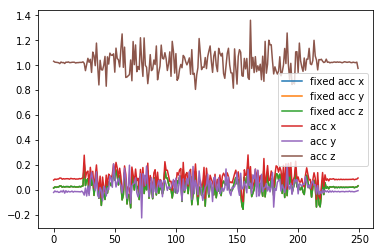

In [87]:
# plt.figure(figsize=(15,15))
# plt.plot(data[:,0], label='left encoder ticks')
# plt.plot(data[:,1], label='right encoder ticks')
# plt.legend()
theta_acc = [-2.71075764e-03, 4.55981725e-03, -7.38354478e-04, 9.97279234e-01, 9.96661774e-01, 9.89959950e-01, -6.37606144e-03, -8.99928659e-03, -1.99175409e-02]  # from the latest data
theta_acc = [-0.05175933, 0.00348791, 0.00268508, 0.99769397, 0.99724823, 0.99706769, -0.00595171, -0.01183456, -0.01726781] # from nicolette 2

T = np.array([[1, -theta_acc[0], theta_acc[1]], [0, 1, -theta_acc[2]], [0, 0, 1]])
K = np.array([[theta_acc[3], 0, 0], [0, theta_acc[4], 0], [0, 0, theta_acc[5]]])
b = np.array([[theta_acc[6], theta_acc[7], theta_acc[8]]])
fixed_accelerometer_data = np.ndarray(accelerometer_data.shape)

for i, a_s in enumerate(accelerometer_data):
    a_o = T@K@(a_s+b).T
    fixed_accelerometer_data[i] = a_o[0]

plt.plot(fixed_accelerometer_data[:,0], label='fixed acc x')
plt.plot(fixed_accelerometer_data[:,1], label='fixed acc y')
plt.plot(fixed_accelerometer_data[:,2], label='fixed acc z')
plt.plot(accelerometer_data[:,0], label='acc x')
plt.plot(accelerometer_data[:,1], label='acc y')
plt.plot(accelerometer_data[:,2], label='acc z')
plt.legend()

plt.show()

In [88]:
def DoubleIntegrateAccelerometer(accelerometer_data, T, K, b):
    x = 0
    y = 0
    vx = 0
    vy = 0
    dt_s = 0.01
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    for a_s in accelerometer_data:
        a_o = T@K@(a_s + b).T
#         print(a_o)
        ax = a_o[0][0]
        ay = a_o[1][0]
        az = a_o[2][0]
        
        vx += ax * dt_s
        vy += ay * dt_s
        x += vx * dt_s + 0.5 * ax * dt_s ** 2
        y += vy * dt_s + 0.5 * ay * dt_s ** 2
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

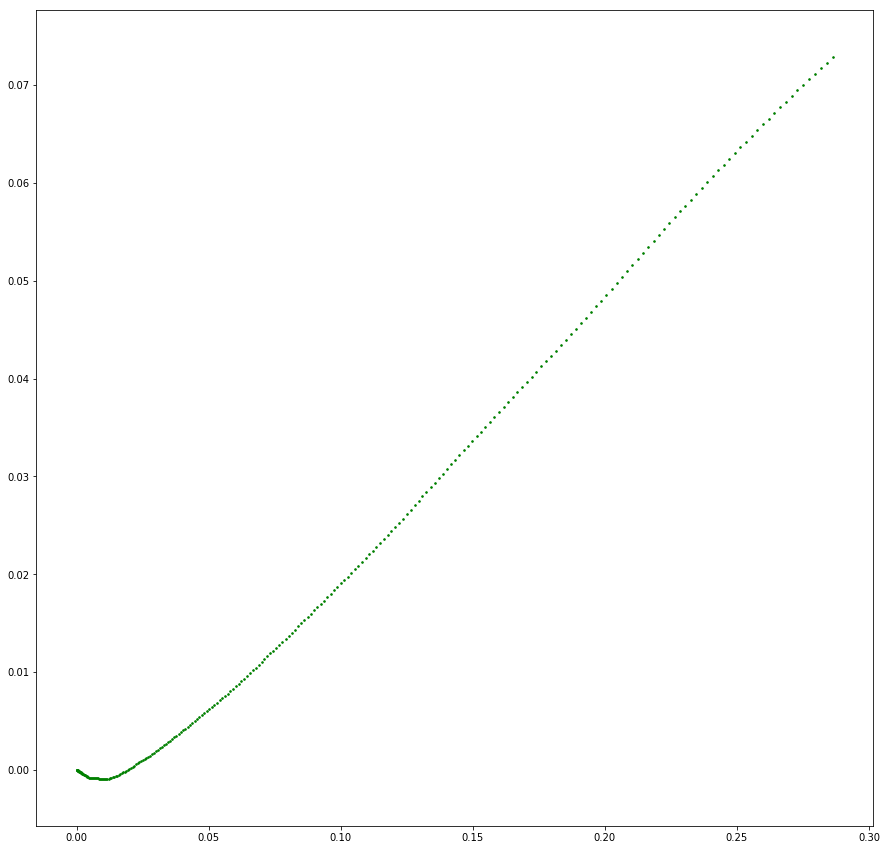

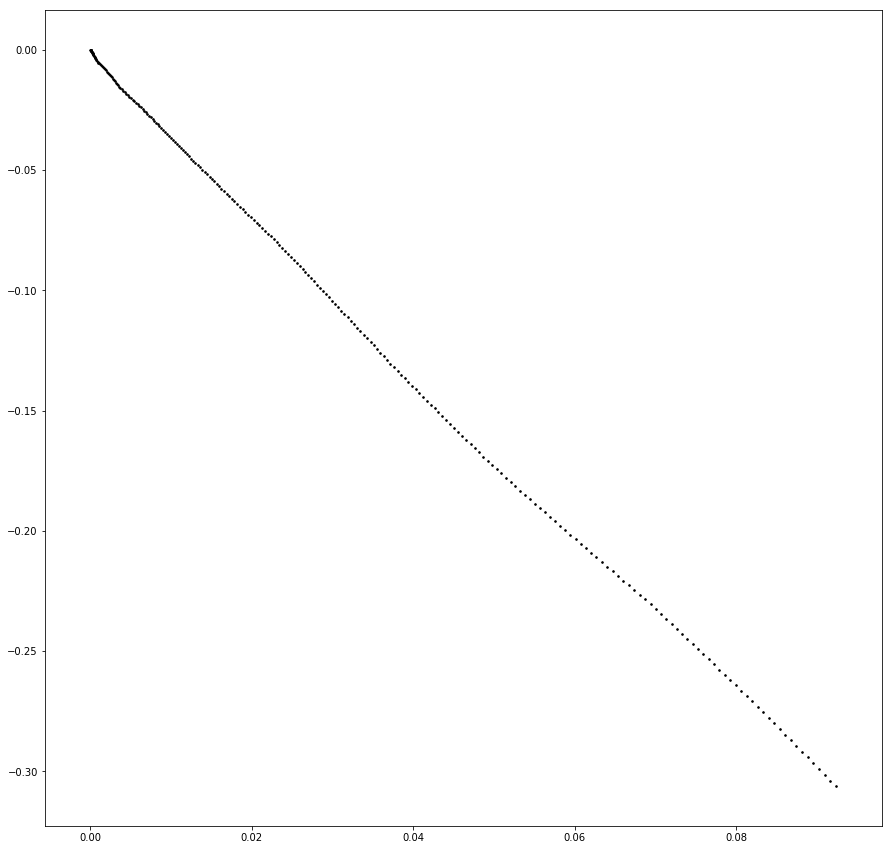

In [89]:
no_bias = DoubleIntegrateAccelerometer(accelerometer_data, np.eye(3), np.eye(3), np.zeros((1,3)))
calib = DoubleIntegrateAccelerometer(accelerometer_data, T, K, b)

plt.figure(figsize=(15,15))
plt.scatter(no_bias[0], no_bias[1], marker='.', s=10, color='g', label='Accelerometer, no bias')

plt.figure(figsize=(15,15))
plt.scatter(calib[0], calib[1], marker='.', s=10, color='k', label='Accelerometer, with bias')
plt.show()